[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1tvzdmCtz5z4bJmGVkA2aFHP8i3UcIEjI#scrollTo=fqE2-WCQVRgh)

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense
import pandas as pd
from DataFormatter import DataFormatter
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from Tab_CNN import CNNModel
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [ ]:
class CNNModel:
    def __init__(self, num_classe,inp_shape):
        self.num_classes = num_classes
        self.input_shape = inp_shape
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=self.input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(Dropout(0.5))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(100, activation='relu'))
        model.add(Dense(units=self.num_classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    def train(self, x_train, y_train, batch_size, epochs):
        history = self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)
        return history

    def evaluate(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

    def predict(self, x):
        return self.model.predict(x)


#replace the path according to the path to the dataset
df = pd.read_csv("Data/WACV_train_data.csv")
df= df.loc[:,"gaze_0_x":]
train_split, val_split = 0.7, 0.15

formatter = DataFormatter(train_split, val_split)
x_train, x_val, x_test, y_train, y_val, y_test = formatter.dataframeFormat(df)
# Instantiate the CNNModel class
num_classes = 3
inp_shape = x_train.shape[1:]
cnn_model = CNNModel(num_classes, inp_shape)

# Train the model
batch_size = 32
epochs = 1
history = cnn_model.train(x_train, y_train, batch_size, epochs)

# Evaluate the model
accuracy = cnn_model.evaluate(x_test, y_test)
print("Test accuracy:", accuracy)

model= cnn_model.model
# make a reference to model's input layer
inp = model.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(4, activation='softmax')

# connect our new layer to the second to last layer in model, and make a reference to it
out = new_classification_layer(model.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

dfD = pd.read_csv("Data/DAiSEE_TL_data.csv")
dfD= dfD.loc[:,"gaze_0_x":]
xD_train, xD_val, xD_test, yD_train, yD_val, yD_test = formatter.dataframeFormat(dfD)

history2 = model_new.fit(xD_train, yD_train, 
                         batch_size=128, 
                         epochs=epochs, 
                         validation_data=(xD_val, yD_val))

#comparing both model's loss and accuracy
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["loss"], label="WACV val loss")
ax.plot(history2.history["loss"], label="DAiSEE val loss")
# ax.set_title("validation loss")
ax.legend(loc="upper left")
ax.set_xlabel("epochs")
ax.set_ylabel("validation loss")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"], label="WACV val accuracy")
ax2.plot(history2.history["accuracy"],label="DAiSEE val accuracy")
# ax2.set_title("validation accuracy")
ax2.legend(loc="lower right")
ax2.set_xlabel("epochs")
ax2.set_ylabel("validation accuracy")
ax2.set_ylim(0, 1)
plt.savefig("Results/TF_los_acc_OF.pdf")
plt.show()

In [ ]:
#Save the model
# serialize model to YAML
model_yaml = model_new.to_json()
with open("Model/model_OF.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model_new.save_weights("Model/model_OF.h5")
print("Saved model to disk")

In [50]:
# load YAML and create model
from tensorflow.keras.models import Sequential, model_from_json
yaml_file = open('Model/model_OF.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_json(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("Model/model_OF.h5")
print("Loaded model from disk")

Loaded model from disk


In [52]:
yD_pred = loaded_model.predict(xD_test)

# Reshape predicted and true labels into binary vectors
y_pred_binary = np.argmax(yD_pred, axis=1)
y_true_binary = np.argmax(yD_test, axis=1)

677/677 [==============================] - 5s 8ms/step


Confusion Matrix:
[[ 125 1267   86    5]
 [  81 8547  886  118]
 [  38 1809 3019  572]
 [   1  544  206 4345]]


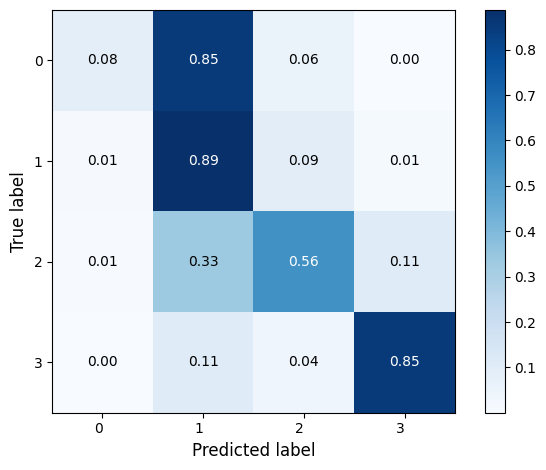

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
          #  title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")
    # Set label sizes
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    # Format the values as percentages
    if normalize:
        fmt = '.2f'
    else:
        fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Compute the confusion matrix
cm = confusion_matrix(y_true_binary, y_pred_binary)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

labels = ['0', '1', '2', '3']
plot_confusion_matrix(y_true_binary, y_pred_binary, classes=labels, normalize=True)
plt.savefig("Results/ConfusionMatD_OF.pdf")
plt.show()
